In [1]:
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()


from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *


thevenin_circuit = Circuit('Thévenin Representation')

thevenin_circuit.V('input', 1, thevenin_circuit.gnd, 10@u_V)
thevenin_circuit.R('generator', 1, 'load', 10@u_Ω)
thevenin_circuit.R('load', 'load', thevenin_circuit.gnd, 1@u_kΩ)

simulator = thevenin_circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.operating_point()

load_node = analysis.load
print('Node {}: {:5.2f} V'.format(str(load_node), float(load_node)))

2021-11-26 12:16:56,531 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Unsupported Ngspice version 34
Node load:  9.90 V


In [2]:
# Load the package for drawing graphs.
import matplotlib.pyplot as plt
# Omit the following line if you're not using a Jupyter notebook.
%matplotlib inline

# Load the SKiDL + PySpice packages and initialize them for doing circuit simulations.
from skidl.pyspice import *
print(lib_search_paths)

2021-11-26 12:16:57,333 - skidl - logger.WARNING - KICAD_SYMBOL_DIR environment variable is missing, so the default KiCad symbol libraries won't be searched.
{'kicad': ['.'], 'skidl': ['.', '/Users/samtaylek/opt/anaconda3/lib/python3.8/site-packages/skidl/libs'], 'spice': ['.']}


### Current Through a Resistor

The following example connects a 1 K$\Omega$ resistor to a voltage source whose value is ramped from 0 to 1 volts. The current through the resistor is plotted versus the applied voltage.

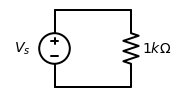

In [3]:
import schemdraw
import schemdraw.elements as elm
d = schemdraw.Drawing(unit=2.5)
L2 = d.add(elm.LINE, d='right')
Rt = d.add(elm.RES, d='up' , botlabel='$1k\Omega$')
L1 = d.add(elm.LINE, d='left', tox=L2.start)
Vt = d.add(elm.SourceV, d='up', xy=L2.start, toy=L1.end, label='$V_s$', lblofst=0.3)
d.draw()
d.save('1_resistor_no_loops.png')
#d.save('1_resistor_no_loops.pdf')
d

   V    I (mA)
  0.00  -0.00
  0.10   0.10
  0.20   0.20
  0.30   0.30
  0.40   0.40
  0.50   0.50
  0.60   0.60
  0.70   0.70
  0.80   0.80
  0.90   0.90
  1.00   1.00



No errors or warnings found during netlist generation.



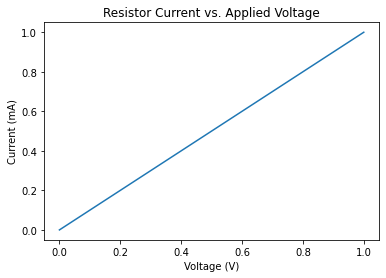

In [4]:
reset()  # This will clear any previously defined circuitry.

# Create and interconnect the components.
vs = V(ref='VS', dc_value = 1 @ u_V)  # Create a voltage source named "VS" with an initial value of 1 volt.
r1 = R(value = 1 @ u_kOhm)            # Create a 1 Kohm resistor.
vs['p'] += r1[1]       # Connect one end of the resistor to the positive terminal of the voltage source.
gnd += vs['n'], r1[2]  # Connect the other end of the resistor and the negative terminal of the source to ground.

# Simulate the circuit.
circ = generate_netlist()              # Translate the SKiDL code into a PyCircuit Circuit object.
sim = circ.simulator()                 # Create a simulator for the Circuit object.
dc_vals = sim.dc(VS=slice(0, 1, 0.1))  # Run a DC simulation where the voltage ramps from 0 to 1V by 0.1V increments.

# Get the voltage applied to the resistor and the current coming out of the voltage source.
voltage = dc_vals[node(vs['p'])]       # Get the voltage applied by the positive terminal of the source.
current = -dc_vals['VS']               # Get the current coming out of the positive terminal of the voltage source.

# Print a table showing the current through the resistor for the various applied voltages.
print('{:^7s}{:^7s}'.format('V', ' I (mA)'))
print('='*15)
for v, i in zip(voltage.as_ndarray(), current.as_ndarray()*1000):
    print('{:6.2f} {:6.2f}'.format(v, i))

# Create a plot of the current (Y coord) versus the applied voltage (X coord).
figure = plt.figure(1)
plt.title('Resistor Current vs. Applied Voltage')
plt.xlabel('Voltage (V)')
plt.ylabel('Current (mA)')
plt.plot(voltage, current*1000) # Plot X=voltage and Y=current (in milliamps, so multiply it by 1000).
plt.show()